# Todo : adding PADOG, Wilcoxon test, KS test method to the notebook


# Enrichment Analysis

Enrichment analysis (EA) is a technique used to derive biological insight from lists of significantly altered genes. The list of genes can be obtained from Differential Expression (DE) analysis or users' interest. The EA methods rely on the knowledge databases (e.g. KEGG and GO) to identify biological pathways or terms that are enriched in a gene list more than would be expected by chance. The outcome of the EA would be the in-depth and contextualized findings to help understand the mechanisms of disease, genes and proteins associated with the etiology of a specific disease or drug target.

Over more than a decade, there are over 50 methods have been developed for EA. In this module, we will focus on pathway analysis using three popular methods including Over Representation Analysis (ORA), Fast Gene Set Enrichment Analysis (FGSEA), and Gene Set Analysis (GSA).

## Learning Objectives:
1. Data preparation
2. Perform enrichment analysis using ORA, FGSEA and GSA
3. Visualize and interpret the outputs

In [2]:
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-1.html" width=100% height=250></iframe>')

## Gene Mapping
In this module, we will use the DE genes with statistic generated in the [**submodule 02** ](./Module02-DE_Analysis.ipynb) using `limma` R package. We can use the following command to load the DE analysis result.

In [3]:
# Load previously saved data
DE.df <- readRDS("./data/DE_genes.rds")
rownames(DE.df) <- DE.df$PROBEID
head(DE.df)

,PROBEID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
222178_s_at,222178_s_at,-0.4473780,0.3653633,-73.01106,4.019112e-55,2.197450e-50,81.05538
224687_at,224687_at,-4.1431631,2.2572347,-48.92036,5.489424e-46,1.500671e-41,74.18354
207488_at,207488_at,-0.4017530,0.6243144,-39.29933,4.735684e-41,8.630785e-37,68.83493
239226_at,239226_at,0.4483302,1.3245501,28.36499,7.626558e-34,1.042455e-29,58.84908
234109_x_at,234109_x_at,-0.2289726,0.7508256,-27.67010,2.635337e-33,2.881741e-29,58.00438
212833_at,212833_at,-2.5976592,1.7308944,-24.01172,2.914912e-30,2.656213e-26,52.99567


We can see that the genes are saved with probe IDs, we need to convert them into gene symbols so that they can be analyzed using the enrichment analysis method later in this module. We will use the same approach presented in the [**submodule 01** ](./Module01-GEO_Data_Processing.ipynb) with `hgu133plus2.db` and `AnnotationDbi` databases.

In [4]:
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4.html" width=100% height=250></iframe>')

In [5]:
# Load the databases
suppressMessages({
    library(hgu133plus2.db)
    library(AnnotationDbi)
})

Then, we can retrieve vector of probe IDs to perform gene symbol mapping using the following command:

In [6]:
probeIDs <- DE.df$PROBEID
# Map probe IDs to their symbols
suppressMessages({
    annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID', 'GENENAME', 'SYMBOL'))
})
# View the first few genes in the mapping table
head(annotLookup)

,PROBEID,GENENAME,SYMBOL
,<chr>,<chr>,<chr>
1,222178_s_at,NA,NA
2,224687_at,ankyrin repeat and IBR domain containing 1,ANKIB1
3,207488_at,NA,NA
4,239226_at,NA,NA
5,234109_x_at,one cut homeobox 3,ONECUT3
6,212833_at,solute carrier family 25 member 46,SLC25A46


Now, we can merge DE data frame with annotation table by the `PROBEID` and remove NA gene symbols using the following command:

In [7]:
DE.df <- merge(annotLookup, DE.df, by = "PROBEID")

In [8]:
# Remove NA gene symbol
DE.df <-  DE.df[!is.na(DE.df$SYMBOL), ]
# Remove duplicated genes
DE.df <-  DE.df[!duplicated(DE.df$SYMBOL, fromLast = FALSE), ]
head(DE.df)

,PROBEID,GENENAME,SYMBOL,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1007_s_at,discoidin domain receptor tyrosine kinase 1,DDR1,-0.23858465,1.0967772,-2.08257585,0.04210211,0.2531265,-4.284228
2,1053_at,replication factor C subunit 2,RFC2,0.05830367,0.9657758,1.42311356,0.16052793,0.4674726,-5.359907
3,117_at,heat shock protein family A (Hsp70) member 6,HSPA6,-0.01138494,1.1501582,-0.08100885,0.93573821,0.9861536,-6.337785
4,121_at,paired box 8,PAX8,0.02301084,1.0581847,0.87166663,0.38729816,0.7236528,-5.968512
5,1255_g_at,guanylate cyclase activator 1A,GUCA1A,0.36999950,1.4080351,1.78615022,0.07976123,0.3351480,-4.812134
6,1294_at,ubiquitin like modifier activating enzyme 7,UBA7,-0.11221434,1.0859983,-1.61593670,0.11200995,0.3925252,-5.082923


As a result, we obtained the new DE table with two more columns containing gene names and gene symbols. The use of this DE table can be varied based on the selected enrichment analysis tools.

## Enrichment Analysis Using Over-Representation Analysis
Over-representation analysis (ORA) is a statistical method that determines whether genes from a pre-defined gene set of a specific GO term or KEGG pathway are presented more than would be expected (over-represented) in a subset of your data. In our learning module, this subset refers to the list of DE genes generated from the `limma` method. For each gene set, an enrichment *p-value* is calculated using the Binomial distribution, Hypergeometric distribution, the Fisher exact test, or the Chi-square test.  The hypergeometric distribution is a popular approach used to calculate enrichment p-value. The formula can be presented as follows:

$$
     P(X\geq x) = 1 - P(X \leq x-1) = 1 - \sum\limits_{i=0}^{x-1}\frac{\hphantom{}{M \choose i }{N - M \choose n-i}}{N \choose n}
$$

where *N* is the number of background genes (all genes presented in the expression matrix), *n* is the number of “interesting” genes (DE genes), *M* is the number of genes that are annotated to a particular gene set *S* (list of genes in a specific KEGG pathway or GO term), and *x* is the number of “interesting” genes that are annotated to *S* (genes presented in DE genes list and a specific KEGG pathway or GO term).

For example, suppose we have an expression matrix with 20,000 genes, of which 500 are differently expressed. Also, suppose that 100 of the 20,000 genes are annotated to a particular gene set S. Of these 100 genes, 20 are members of the DE genes list. The probability that 20 or more (up to 100) genes annotated to S are in the DE genes list by chance is given by

$$
P(X\geq 20) = 1 - P(X \leq 19) = 1-\sum \limits_{i=0}^{19}\frac{\hphantom{}{100 \choose i}{20000 - 100 \choose 500-i}}{20000 \choose 500} = 5.26 \times 10^{-13}
$$

The *p-value* indicates that it is very rare to observe 20 of the 100 genes from this set are in the DE genes list by chance.

In [9]:
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-2.html" width=100% height=250></iframe>')

### Data preparation
To conduct enrichment analysis using ORA, there are several input data that we need to prepare. First, we need to select a set of genes that
are significantly altered (*p-value < 0.05*) in the DE genes generated from the `limma` method.

In [10]:

# Selecting a list of significant DE genes
DEGenes <- DE.df[DE.df$adj.P.Val <= 0.05, ]
# Select genes with symbol
DEGenes <- DEGenes$SYMBOL

Next, we need to define a list of background genes. In this analysis, they are all the genes generated from the DE analysis.

In [11]:
#Defining background genes
backgroundSet <- DE.df$SYMBOL

Then, we need to obtain a list of geneset from knowledge databases such as GO and KEGG. In this learning module, the geneset will be retrieved from
the *.gmt* files that were processed from the [**submodule 03**](./Module03-Gene_Set_and_Pathway.ipynb). To load the geneset, we will use the `gmt2geneset` function below:

Here, we also write a function to perform over-representation analysis based on the hyper-geometric testing formula presented above. The `ORA` method will perform
hyper-geometric testing for each geneset obtained from GO or KEGG using the function `phyper` available for the `stats` R base package. The output of the `ORA` function is a table that contains a column of terms or pathway names and a column of *p-value*.

In [12]:
# A customized function to parse a gmt file to a list of genesets
gmt2geneset <- function(path) {
    # Read the GMT file and create a list of gene sets
    gmt_content <- read.table(path, header = FALSE, fill = TRUE, sep = "\t")
    
    genesets <- apply(gmt_content, MARGIN = 1, function(r) {
        # Extract unique genes from the current row (excluding the first two elements)
        genes = unique(r[-(1:2)]) 
        # Create a list for each gene set with ID, description, and non-NA genes
        list(
            id = r[1],
            description = r[2],
            genes = genes[!is.na(genes)]
        )
    })
    # Extract the gene sets from the list and convert gene vectors to character
    gs <- lapply(genesets, function(g) {
        as.character(g$genes)
    })
    # Set names for the gene sets based on their descriptions
    names(gs) <- lapply(genesets, function(g) g$description)
    # Return the resulting list of gene sets
    return (gs)
}



In [13]:
# Over-Representation Analysis (ORA) Function
ORA <- function(geneset, DEGenes, backgroundSet, DE.df) {
    # Initialize an empty vector to store the results of the analysis
    res <- sapply(geneset, function(gs) {
        # Count the number of differentially expressed genes in the current gene set (gs)
        wBallDraw <- length(intersect(gs, DEGenes)) - 1
        # Check for a potential issue with the intersection count being negative
        if (wBallDraw < 0) return(1)
        # Total number of differentially expressed genes
        wBall <- length(DEGenes)
        # Remaining genes in the background set
        bBall <- nrow(DE.df) - length(DEGenes)
        # Number of genes in the current gene set that are in the background set
        ballDraw <- length(intersect(gs, backgroundSet))
        # Calculate the hypergeometric probability using the phyper function
        hypergeo_prob <- phyper(wBallDraw, wBall, bBall, ballDraw)
        # Calculate the complementary probability (1 - hypergeometric probability)
        return(1 - hypergeo_prob)
    })
    # Return the vector of results (p-values)
    return(res)
}


To use the `ORA` function, we need to pass the following arguments:

- `geneset`: A list of gene sets to be analyzed.
- `DEGenes`: A vector of differentially expressed genes.
- `backgroundSet`: A vector containing a set of genes representing the background.
- `DE.df`: A dataframe containing information about differentially expressed genes.

The `ORA` function returns a vector of the results (p-values).

### Enrichment analysis using ORA and GO terms
In this section, we will perform ORA using genesets obtained from the GO database and the function `ORA` defined above. The detailed code is presented below:

In [14]:
# Loading geneset from GO database
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# Perform ORA
res.ORA <- ORA(geneset = geneset, DEGenes = DEGenes, backgroundSet = backgroundSet, DE.df = DE.df)
# Save the result to a table where the first column is GO term name and the second column is the p-value
res.df <- data.frame(
    GOterms = names(res.ORA),
    pvalue = res.ORA
)
# Order the table based on the p-value
res.df <- res.df[order(res.df$pvalue), ]
# View the most significant GO terms
head(res.df)

,GOterms,pvalue
,<chr>,<dbl>
601,"mitochondrial electron transport, cytochrome c to oxygen",0.0001704211
1854,energy derivation by oxidation of organic compounds,0.0004553500
2204,respiratory electron transport chain,0.0004962063
2203,electron transport chain,0.0009369785
598,oxidative phosphorylation,0.0013190484
1282,aerobic respiration,0.0016870236


From the result table, we might conclude that the pathways shown are key components of the disease in study.

### Enrichment analysis using ORA and KEGG pathways

We will perform the same steps as we did above for the GO terms.

In [15]:
# Loading the KEGG pathways
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})

In [16]:
# Perform Hyper-geometric testing
res.ORA <- ORA(geneset = geneset, DEGenes = DEGenes, 
               backgroundSet = backgroundSet, DE.df = DE.df)
# Save the results to a data frame
res.df <- data.frame(
    pathways = names(res.ORA),
    pvalue = res.ORA
)

res.df <- res.df[order(res.df$pvalue), ]
head(res.df)


,pathways,pvalue
,<chr>,<dbl>
622,UQCRH,0.0008616251
680,COX2,0.0008753422
670,CYC1,0.0057312227
17,COX5A,0.0060597917
472,SDHC,0.0060597917
612,SDHC,0.0060597917


### Enrichment analysis using ORA and REACTOME pathways

We will perform basically the same steps as we did above for the GO terms and KEEG pathways, the only thing that is different is we will map the PROBEID to ENTREZID instead of SYMBOL since REACTOME use the ENTREZID for gene id.

In [17]:
probeIDs <- DE.df$PROBEID

suppressMessages({
    annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID', 'ENTREZID'))
})
head(annotLookup)

DE.df <- merge(annotLookup, DE.df, by = "PROBEID")

# Remove NA gene symbol
DE.df <-  DE.df[!is.na(DE.df$ENTREZID), ]
# Remove duplicated genes
DE.df <-  DE.df[!duplicated(DE.df$ENTREZID, fromLast = FALSE), ]
head(DE.df)


,PROBEID,ENTREZID
,<chr>,<chr>
1,1007_s_at,780
2,1053_at,5982
3,117_at,3310
4,121_at,7849
5,1255_g_at,2978
6,1294_at,7318


,PROBEID,ENTREZID,GENENAME,SYMBOL,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1007_s_at,780,discoidin domain receptor tyrosine kinase 1,DDR1,-0.23858465,1.0967772,-2.08257585,0.04210211,0.2531265,-4.284228
2,1053_at,5982,replication factor C subunit 2,RFC2,0.05830367,0.9657758,1.42311356,0.16052793,0.4674726,-5.359907
3,117_at,3310,heat shock protein family A (Hsp70) member 6,HSPA6,-0.01138494,1.1501582,-0.08100885,0.93573821,0.9861536,-6.337785
4,121_at,7849,paired box 8,PAX8,0.02301084,1.0581847,0.87166663,0.38729816,0.7236528,-5.968512
5,1255_g_at,2978,guanylate cyclase activator 1A,GUCA1A,0.36999950,1.4080351,1.78615022,0.07976123,0.3351480,-4.812134
6,1294_at,7318,ubiquitin like modifier activating enzyme 7,UBA7,-0.11221434,1.0859983,-1.61593670,0.11200995,0.3925252,-5.082923


In [18]:
# Selecting a list of significant DE genes
DEGenes <- DE.df[DE.df$adj.P.Val <= 0.05, ]
# Select genes with symbol
DEGenes <- DEGenes$ENTREZID
#Defining background genes
backgroundSet <- DE.df$ENTREZID

In [19]:
# Loading geneset from GO database
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/REACTOME_pathways.gmt")})})
# Perform ORA
res.ORA <- ORA(geneset = geneset, DEGenes = DEGenes, backgroundSet = backgroundSet, DE.df = DE.df)
# Save the result to a table where the first column is GO term name and the second column is the p-value
res.df <- data.frame(
    pathways = names(res.ORA),
    pvalue = res.ORA
)
# Order the table based on the p-value
res.df <- res.df[order(res.df$pvalue), ]
# View the most significant GO terms
head(res.df)

,pathways,pvalue
,<chr>,<dbl>
1278,5264,0.0007996188
2879,Homo sapiens: Type I hemidesmosome assembly,0.0054458977
1651,Homo sapiens: P2Y receptors,0.0066064555
2202,Homo sapiens: Ribavirin ADME,0.0066064555
1863,Homo sapiens: Protein folding,0.0091140070
1971,84271,0.0091140070


# Enrichment analysis using KS and Wilcoxon test

The Kolmogorov-Smirnov (KS) test is a non-parametric test that compares the cumulative distribution functions of two datasets. In the context of enrichment analysis, it can be employed to assess whether the distribution of DE genes is significantly different from what would be expected by chance for a given gene set. The test produces a KS statistic and a corresponding p-value, indicating the degree of over-representation.

The Wilcoxon test, also known as the Mann-Whitney U test, is another non-parametric test used in enrichment analysis. It assesses whether there is a significant difference in the ranks of genes between the DE gene set and the rest of the genes.

### Data preparation
To conduct enrichment analysis using KS or Wilcoxon test, we will use the limma DE result as input. First, we can use the DE.df variable above and select a set of genes that
are significantly altered (*p-value < 0.05*).

In [20]:
# Select genes that are significantly altered
kw_de <- DE.df[DE.df$adj.P.Val <= 0.05, ]
head(kw_de)

,PROBEID,ENTREZID,GENENAME,SYMBOL,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
146,1552467_at,259234,Down syndrome critical region 10,DSCR10,0.07632117,1.1024122,3.721644,4.778227e-04,4.325324e-02,-0.28303673
149,1552473_at,2593,guanidinoacetate N-methyltransferase,GAMT,0.12655694,1.0378989,3.829094,3.402464e-04,3.481091e-02,0.03057276
175,1552514_at,164684,WBP2 N-terminal like,WBP2NL,-0.43701990,1.2072571,-3.705169,5.031544e-04,4.458666e-02,-0.33067421
181,1552524_at,116969,ADP-ribosyltransferase 5,ART5,-0.15248106,1.2214668,-5.601889,7.601467e-07,3.172597e-04,5.74686253
220,1552596_at,246176,growth arrest specific 2 like 2,GAS2L2,0.09704702,0.9937790,8.231539,4.578441e-11,4.490998e-08,14.90292753
381,1552768_at,84254,calcium/calmodulin dependent protein kinase kinase 1,CAMKK1,0.07873062,0.8284583,3.985720,2.057635e-04,2.541044e-02,0.49642261


Next, we will remove rows containing NA, dupicated genes symbol.

In [21]:
# Remove NA value
kw_de <- kw_de[!is.na(kw_de$SYMBOL), ]
# Remove duplicated genes symbol
kw_de <- kw_de[!duplicated(kw_de$SYMBOL, fromLast = FALSE), ]
rownames(kw_de) <- kw_de$SYMBOL
# remove the first 3 columns from the DE dataframe  
kw_de <- kw_de[, -c(1:3)]
head(kw_de)

,SYMBOL,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DSCR10,DSCR10,0.07632117,1.1024122,3.721644,4.778227e-04,4.325324e-02,-0.28303673
GAMT,GAMT,0.12655694,1.0378989,3.829094,3.402464e-04,3.481091e-02,0.03057276
WBP2NL,WBP2NL,-0.43701990,1.2072571,-3.705169,5.031544e-04,4.458666e-02,-0.33067421
ART5,ART5,-0.15248106,1.2214668,-5.601889,7.601467e-07,3.172597e-04,5.74686253
GAS2L2,GAS2L2,0.09704702,0.9937790,8.231539,4.578441e-11,4.490998e-08,14.90292753
CAMKK1,CAMKK1,0.07873062,0.8284583,3.985720,2.057635e-04,2.541044e-02,0.49642261


In [22]:
dim(kw_de)

[1] 241   7

To perform KS or Wilcoxon test, we will use the `.runKsWilcox` function bellow.

In [23]:
.runKsWilcox <- function(DE.df, statCol, genesets, sTest) {
    # remove rows that contain NA value in adj.P.Val column
    DE_data <- DE.df[!is.na(DE.df[[statCol]]), ]
    # get the adjusted p-values from DE.df to perform the test
    ranks <- DE_data[[statCol]]
    # set names of the DE genes
    names(ranks) <- rownames(DE_data)

    # choose the test to perform based on the sTest argument
    test <- if (sTest == "ks") ks.test else wilcox.test
    
    background.genes <- rownames(DE_data)

    DEhit <- sapply(genesets, function(gs) ranks[background.genes[background.genes %in% gs]])
    DEmiss <- sapply(genesets, function(gs) ranks[background.genes[!background.genes %in% gs]])

    # Initialize an empty list to store results
    PA_res_list <- lapply(1:length(DEhit), function(i) {
        cur.DEhit <- DEhit[[i]]
        cur.DEmiss <- DEmiss[[i]]
    
        # Check if either list is empty
        if (length(cur.DEhit) == 0 | length(cur.DEmiss) == 0) return(1)
    
        # Perform the test and extract the p-value
        test_result <- test(cur.DEhit, cur.DEmiss)
        test_result$p.value
    })
    
    # Combine the results into a data frame
    PA_res <- data.frame(
        ID = names(genesets),
        p.value = unlist(PA_res_list),
        stringsAsFactors = FALSE
    )
    
    # Remove rows with missing values
    PA_res <- PA_res[complete.cases(PA_res), ]
    # Ensure row names are unique
    PA_res$ID <- make.unique(PA_res$ID)
    # Set row names
    rownames(PA_res) <- PA_res$ID

    return(PA_res)
    
}

To use the `.runKsWilcox` function, we need to pass the following arguments:

- `DE.df`: A dataframe containing information about differentially expressed genes.
- `statCol`: A character string specifying the column in the DE.df data frame that contains the statistical values (e.g., p-value, adjusted p-values) associated with each gene.
- `geneset`: A list of gene sets to be analyzed.
- `sTest`: A character string specifying the testing method to be used; it can take either "ks" for the Kolmogorov-Smirnov test or "wilcox" for the Wilcoxon test.

The `.runKsWilcox` function returns a dataframe of the analysis result.


### Enrichment analysis using KS and GO terms

We will need a gene set to perform enrichment analysis using KS/Wilcoxon test. Here, we will use the GO terms saved in the "GO_terms.gmt" file in module 3.

In [24]:
# load the GO gene sets from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# perform enrichment analysis using KS test
suppressWarnings(k_results <- .runKsWilcox(DE.df = kw_de, statCol = "adj.P.Val", geneset = geneset, sTest = "ks"))

# order the results 
k_results <- k_results[order(k_results$p.value), ]
# show some first rows of the result table
head(k_results)

,ID,p.value
,<chr>,<dbl>
cellular respiration,cellular respiration,0.0001154964
aerobic respiration,aerobic respiration,0.0003372217
oxidative phosphorylation,oxidative phosphorylation,0.0010481317
respiratory electron transport chain,respiratory electron transport chain,0.0010481317
leukocyte apoptotic process,leukocyte apoptotic process,0.0024896266
signal transduction,signal transduction,0.0042530813


### Enrichment analysis using KS and KEGG pathways
To do the analysis with KEEG pathways, we simply replace the GO gene sets with the KEGG pathways.

In [25]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})
# perform enrichment analysis using KS test
k_results <- .runKsWilcox(DE.df = kw_de, statCol = "adj.P.Val", geneset = geneset, sTest = "ks")

# order the results 
k_results <- k_results[order(k_results$p.value), ]
# show some first rows of the result table
head(k_results)

,ID,p.value
,<chr>,<dbl>
Complement and coagulation cascades - Homo sapiens (human),Complement and coagulation cascades - Homo sapiens (human),0.01317731
COX5A,COX5A,0.01447322
SDHC,SDHC,0.01447322
SDHC.1,SDHC.1,0.01447322
COX2,COX2,0.01447322
NDUFA4L2,NDUFA4L2,0.01447322


### Enrichment analysis using KS and REACTOME pathways
To do the analysis with REACTOME pathways, we will use the same steps as for GO terms and KEEG pathways. But instead of select the SYMBOL column to set for row names, we will use the ENTREZID column.

In [26]:
# Select genes that are significantly altered
kwR_de <- DE.df[DE.df$adj.P.Val <= 0.05, ]
head(kwR_de)

# Remove NA value
kwR_de <- kwR_de[!is.na(kwR_de$ENTREZID), ]
# Remove duplicated genes symbol
kwR_de <- kwR_de[!duplicated(kwR_de$ENTREZID, fromLast = FALSE), ]
rownames(kwR_de) <- kwR_de$ENTREZID
# remove the first 3 columns from the DE dataframe  
kwR_de <- kwR_de[, -c(1:3)]
head(kwR_de)

,PROBEID,ENTREZID,GENENAME,SYMBOL,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
146,1552467_at,259234,Down syndrome critical region 10,DSCR10,0.07632117,1.1024122,3.721644,4.778227e-04,4.325324e-02,-0.28303673
149,1552473_at,2593,guanidinoacetate N-methyltransferase,GAMT,0.12655694,1.0378989,3.829094,3.402464e-04,3.481091e-02,0.03057276
175,1552514_at,164684,WBP2 N-terminal like,WBP2NL,-0.43701990,1.2072571,-3.705169,5.031544e-04,4.458666e-02,-0.33067421
181,1552524_at,116969,ADP-ribosyltransferase 5,ART5,-0.15248106,1.2214668,-5.601889,7.601467e-07,3.172597e-04,5.74686253
220,1552596_at,246176,growth arrest specific 2 like 2,GAS2L2,0.09704702,0.9937790,8.231539,4.578441e-11,4.490998e-08,14.90292753
381,1552768_at,84254,calcium/calmodulin dependent protein kinase kinase 1,CAMKK1,0.07873062,0.8284583,3.985720,2.057635e-04,2.541044e-02,0.49642261


,SYMBOL,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
259234,DSCR10,0.07632117,1.1024122,3.721644,4.778227e-04,4.325324e-02,-0.28303673
2593,GAMT,0.12655694,1.0378989,3.829094,3.402464e-04,3.481091e-02,0.03057276
164684,WBP2NL,-0.43701990,1.2072571,-3.705169,5.031544e-04,4.458666e-02,-0.33067421
116969,ART5,-0.15248106,1.2214668,-5.601889,7.601467e-07,3.172597e-04,5.74686253
246176,GAS2L2,0.09704702,0.9937790,8.231539,4.578441e-11,4.490998e-08,14.90292753
84254,CAMKK1,0.07873062,0.8284583,3.985720,2.057635e-04,2.541044e-02,0.49642261


In [27]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/REACTOME_pathways.gmt")})})
# perform enrichment analysis using KS test
k_results <- .runKsWilcox(DE.df = kwR_de, statCol = "adj.P.Val", geneset = geneset, sTest = "ks")

# order the results 
k_results <- k_results[order(k_results$p.value), ]
# show some first rows of the result table
head(k_results)

,ID,p.value
,<chr>,<dbl>
Homo sapiens: Activation of HOX genes during differentiation,Homo sapiens: Activation of HOX genes during differentiation,0.007936508
Homo sapiens: Activation of anterior HOX genes in hindbrain development during early embryogenesis,Homo sapiens: Activation of anterior HOX genes in hindbrain development during early embryogenesis,0.007936508
Homo sapiens: Regulation of gene expression in early pancreatic precursor cells,Homo sapiens: Regulation of gene expression in early pancreatic precursor cells,0.007936508
Homo sapiens: Regulation of gene expression in late stage (branching morphogenesis) pancreatic bud precursor cells,Homo sapiens: Regulation of gene expression in late stage (branching morphogenesis) pancreatic bud precursor cells,0.007936508
Homo sapiens: RNA polymerase II transcribes snRNA genes,Homo sapiens: RNA polymerase II transcribes snRNA genes,0.015873016
Homo sapiens: AKT phosphorylates targets in the nucleus,Homo sapiens: AKT phosphorylates targets in the nucleus,0.023809524


### Enrichment analysis using WILCOXON and GO terms

For enrichment analysis with Wilcoxon test, we simply pass the value "wilcox" to the *sTest* argument in the `.runKsWilcox` function. We will do the same steps as KS test.

In [28]:
# load the GO gene sets from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# perform enrichment analysis with Wilcoxon test 
w_results <- .runKsWilcox(DE.df = kw_de, statCol = "adj.P.Val", geneset = geneset, sTest = "wilcox")

# order the result  
w_results <- w_results[order(w_results$p.value), ]
# show some first rows of the result
head(w_results)

,ID,p.value
,<chr>,<dbl>
cellular respiration,cellular respiration,0.0006071947
aerobic respiration,aerobic respiration,0.0022047165
energy derivation by oxidation of organic compounds,energy derivation by oxidation of organic compounds,0.0036405380
oxidative phosphorylation,oxidative phosphorylation,0.0041849457
MAP10,MAP10,0.0042461484
generation of precursor metabolites and energy,generation of precursor metabolites and energy,0.0043314488


### Enrichment analysis using WILCOXON and KEGG pathways


In [29]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})
# perform enrichment analysis with Wilcoxon test 
w_results <- .runKsWilcox(DE.df = kw_de, statCol = "adj.P.Val", geneset = geneset, sTest = "wilcox")

# order the result  
w_results <- w_results[order(w_results$p.value), ]
# show some first rows of the result
head(w_results)

,ID,p.value
,<chr>,<dbl>
COX5A,COX5A,0.02472462
SDHC,SDHC,0.02472462
SDHC.1,SDHC.1,0.02472462
COX2,COX2,0.02472462
CYC1,CYC1,0.02472462
Complement and coagulation cascades - Homo sapiens (human),Complement and coagulation cascades - Homo sapiens (human),0.02692431


### Enrichment analysis using WILCOXON and REACTOME pathways


In [30]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/REACTOME_pathways.gmt")})})
# perform enrichment analysis using KS test
k_results <- .runKsWilcox(DE.df = kwR_de, statCol = "adj.P.Val", geneset = geneset, sTest = "wilcox")

# order the results 
k_results <- k_results[order(k_results$p.value), ]
# show some first rows of the result table
head(k_results)

,ID,p.value
,<chr>,<dbl>
1329,1329,0.03413802
84271,84271,0.06002829
Homo sapiens: Respiratory electron transport,Homo sapiens: Respiratory electron transport,0.06636071
Homo sapiens: Complex I biogenesis,Homo sapiens: Complex I biogenesis,0.08040866
Homo sapiens: Activation of HOX genes during differentiation,Homo sapiens: Activation of HOX genes during differentiation,0.08573066
Homo sapiens: Activation of anterior HOX genes in hindbrain development during early embryogenesis,Homo sapiens: Activation of anterior HOX genes in hindbrain development during early embryogenesis,0.08573066


## Enrichment Analysis using FGSEA

This submodule describes `FGSEA`, one of the methods for evaluating pathway enrichment in transcriptional data and it stands for Fast preranked Gene Set Enrichment Analysis (GSEA). `FGSEA` quickly calculates arbitrarily low GSEA P-values for a collection of gene sets and is based on an algorithm that allows  it to make more permutations and get accurate *p-values*.
It extends the GSEA algorithm which calculates the enrichment score (the degree to which a set S is over-represented at the top or bottom of the ranked list L), estimates the p-value of the Enrichment Score using a permutation test and adjusts the estimated significance level to account for multiple hypotheses in addition to calculating the q-values for FDR control. Typically, GSEA requires inputs of a list of gene sets (GO term or pathway with a set of genes), a vector DE genes with statistic. In addition, users can limit the number of terms or pathways of interest by adjusting the `minSize` and `maxSize` parameters. The code to install and load the FGSEA R package is shown below:

In [31]:
# To perform enrichment analysis using FGSEA, we first install the fgsea package
suppressMessages({
    if (!require("BiocManager", quietly = TRUE)) {
        install.packages("BiocManager")
        suppressWarnings(BiocManager::install("fgsea", update = F))
    }
})

In [32]:
# Loading the package
suppressPackageStartupMessages({
    library("fgsea")
})

In [33]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-3.html" width=100% height=250></iframe>')

Next, we need to prepare a vector of DE genes with its statistic.

In [34]:
# Get the gene list and their statistic from DE results
stats = DE.df$adj.P.Val
names(stats) = DE.df$SYMBOL
head(stats)

DDR1      RFC2     HSPA6      PAX8    GUCA1A      UBA7 
0.2531265 0.4674726 0.9861536 0.7236528 0.3351480 0.3925252

### Enrichment analysis using FGSEA and GO terms

The package `fgsea` has its own function named `gmtPathways` to load the genesets from the `gmt` file. It is recommended to use this function for compatibility. We can load the GO terms geneset and view the first five GO terms with associated genes using the following command:

In [35]:
# Load the pathways into a named list
GO_term_hallmark <- gmtPathways("./data/GO_terms.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(GO_term_hallmark, head)
tmp[1:5]

$`GO:0000002`
[1] "AKT3"   "DNA2"   "DNAJA3" "ENDOG"  "FLCN"   "LIG3"  

$`GO:0000003`
[1] "A1CF"  "A2M"   "AAAS"  "ABAT"  "ABCC8" "ABHD2"

$`GO:0000012`
[1] "APLF"  "APTX"  "ERCC6" "ERCC8" "LIG4"  "PARP1"

$`GO:0000018`
[1] "ABL1"   "ACTB"   "ACTL6A" "ACTR2"  "ALYREF" "ANKLE1"

$`GO:0000022`
[1] "AURKB"  "AURKC"  "BIRC5"  "CDCA8"  "INCENP" "KIF23"

Running the FGSEA can be done by calling the `fgsea` with two required inputs that we created from the two previous steps.

In [36]:
# Running fgsea
suppressWarnings(
    fgseaRes <- fgsea(pathways = GO_term_hallmark, stats = stats)
)

To use the `fgsea` function, we need to pass the following arguments:

- `pathways`: A list of gene sets to check.
- `stats`: A named vector of gene-level stats. Names should be the same as in 'pathways'.

The `fgsea` function returns a dataframe with GSEA results. Each row corresponds to a tested pathway.


The output of the FGSEA method is a table where rows are GO terms IDs or pathway IDs. The columns are *p-values*, *adjusted p-values*, *Enrichment Score*, etc.

In [37]:
head(fgseaRes[order(pval), ][, -8])

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GO:0006122,8.754388e-06,0.06000257,0.5933255,-0.7106070,-2.620884,11
GO:0060390,1.829102e-05,0.06268331,0.5756103,0.4911948,1.862244,46
GO:0050907,4.798773e-05,0.10963597,0.5573322,0.3756389,1.551850,128
GO:0030850,1.099860e-04,0.18846105,0.5384341,0.4547892,1.743769,51
GO:0007606,1.802479e-04,0.22144289,0.5188481,0.3392928,1.432718,178
GO:0009593,1.938514e-04,0.22144289,0.5188481,0.3497537,1.463237,159


From the result table, we can select top five up regulated GO terms and top five down regulated GO terms. Then we can plot them using the built-in function `plotGseaTable`

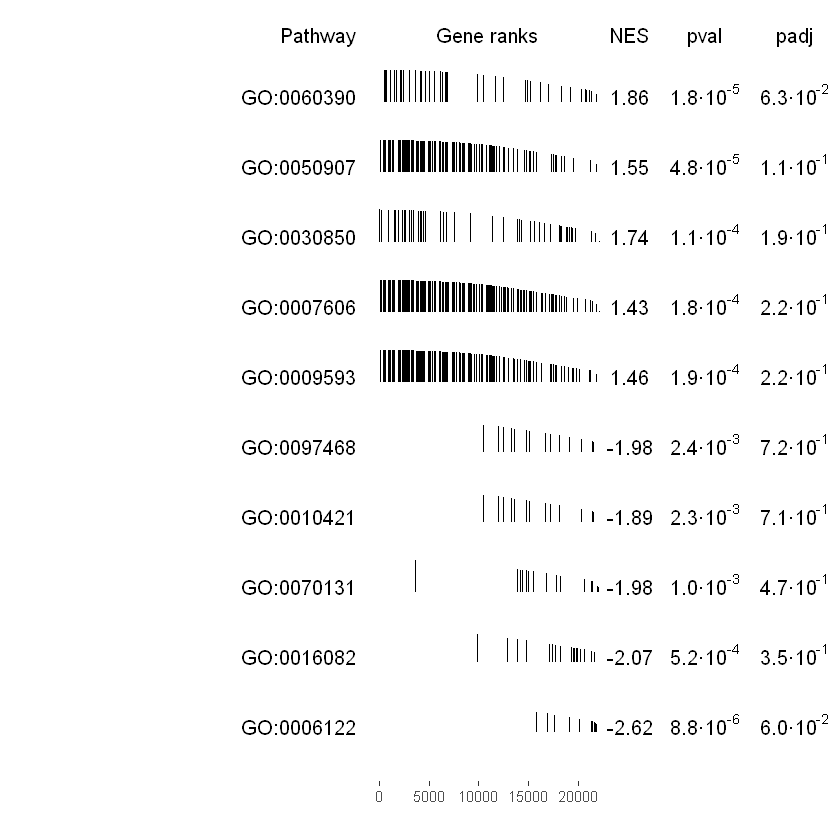

In [38]:
topGOUp <- fgseaRes[ES > 0][head(order(pval), n = 5), pathway]
topGODown <- fgseaRes[ES < 0][head(order(pval), n = 5), pathway]
topGO <- c(topGOUp, rev(topGODown))
# create the plot
plotGseaTable(pathways = GO_term_hallmark[topGO], stats = stats, 
              fgseaRes = fgseaRes, gseaParam = 0.5)

To use the `plotGseaTable` function, we need to pass the following arguments:

- `pathways`: A list of pathways to plot table.
- `stats`: A dataframe specifying gene-level stats.
- `fgseaRes`: A dataframe of fgsea results.
- `gseaParam`: A numeric value to adjust displayed statistic values, values closer to 0 flatten plots. Default = 1, value of 0.5 is a good choice too.

### Enrichment analysis using FGSEA and KEGG pathways
We can perform enrichment analysis using FGSEA with KEGG pathway using the same procedure mentioned above. The only thing we need to change is the
list of genesets that are available in the KEGG database.

In [39]:
# Load the pathways into a named list
KEGG_hallmark <- gmtPathways("./data/KEGG_pathways.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(KEGG_hallmark, head)
tmp[1:5]

$hsa00010
[1] "HK3"   "HK1"   "HK2"   "HKDC1" "GCK"   "GPI"  

$hsa00020
[1] "CS"   "ACLY" "ACO2" "ACO1" "IDH1" "IDH2"

$hsa00030
[1] "GPI"  "G6PD" "PGLS" "H6PD" "PGD"  "RPE" 

$hsa00040
[1] "GUSB"    "KL"      "UGT2A1"  "UGT2A3"  "UGT2B17" "UGT2B11"

$hsa00051
[1] "MPI"   "PMM2"  "PMM1"  "GMPPB" "GMPPA" "GMDS"

In [40]:
# Running fgsea
suppressWarnings(
    fgseaRes <- fgsea(pathways = KEGG_hallmark, stats = stats)
)

In [41]:
head(fgseaRes[order(pval), ][, -8])

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
hsa04060,4.044034e-06,0.001374972,0.6105269,0.3328477,1.436012,290
hsa04740,1.058477e-03,0.179941158,0.4550599,0.3505170,1.429992,120
hsa04061,5.614319e-03,0.636289434,0.4070179,0.3461236,1.391701,96
hsa04080,8.145521e-03,0.692369245,0.3807304,0.2779229,1.210259,356
hsa05340,1.279142e-02,0.869816875,0.3807304,0.4011639,1.445081,37
hsa03460,2.330367e-02,1.000000000,0.3524879,0.3637500,1.374373,52


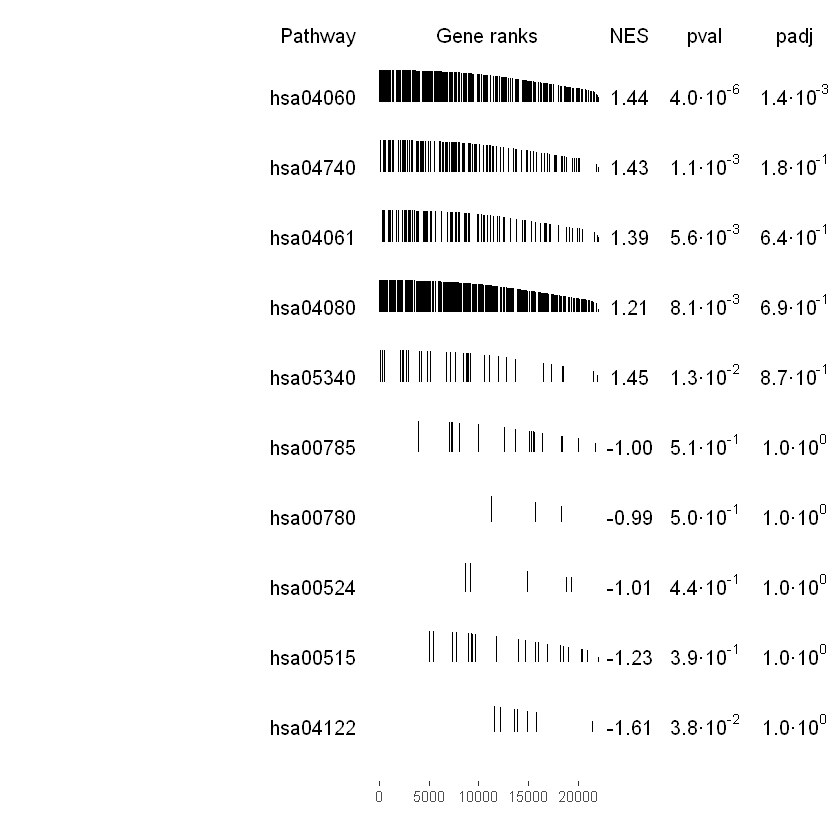

In [42]:
# select the top five up-regulated pathways 
topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n = 5), pathway]
# select the top five down-regulated pathways 
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n = 5), pathway]
# concatenate them for visualization
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
#Viewing the 5 most significantly up-regulated and down-regulated pathways each with the FGSEA internal plot function
plotGseaTable(pathways = KEGG_hallmark[topPathways], stats = stats, 
              fgseaRes = fgseaRes, gseaParam = 0.5)

### Enrichment analysis using FGSEA and REACTOME pathways
We can perform enrichment analysis using FGSEA with REACTOME pathways using the same procedure mentioned above. The only thing we need to change is the
list of genesets that are available in the REACTOME database and the gene id (from SYMBOL to ENTREZID).

In [81]:
# Get the gene list and their statistic from DE results
stats = DE.df$adj.P.Val
names(stats) = DE.df$ENTREZID
head(stats)

780      5982      3310      7849      2978      7318 
0.2531265 0.4674726 0.9861536 0.7236528 0.3351480 0.3925252

In [82]:
# Load the pathways into a named list
REACTOME_hallmark <- gmtPathways("./data/REACTOME_pathways.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(REACTOME_hallmark, head)
tmp[1:5]

$`R-HSA-164843`
[1] "8815"   "155348" "155030" "11168"  "7518"   "3981"  

$`R-HSA-73843`
[1] "5634"   "5631"   "221823"

$`R-HSA-1971475`
[1] "221914" "27087"  "10675"  "1464"   "3339"   "633"   

$`R-HSA-5619084`
[1] "122706" "5716"   "26154"  "5826"   "5682"   "8647"  

$`R-HSA-1369062`
[1] "20"    "64241" "225"   "64240" "10347" "21"

In [83]:
# Running fgsea
suppressWarnings(
    fgseaRes <- fgsea(pathways = REACTOME_hallmark, stats = stats)
)

In [84]:
head(fgseaRes[order(pval), ][, -8])

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
R-HSA-6805567,4.182288e-06,0.01056446,0.6105269,0.3884187,1.607719,140
R-HSA-381753,1.530411e-04,0.15176876,0.5188481,0.3841968,1.549905,101
R-HSA-9752946,1.802479e-04,0.15176876,0.5188481,0.3910022,1.569605,94
R-HSA-500792,2.529114e-04,0.15971358,0.4984931,0.2906890,1.282994,453
R-HSA-6809371,5.174794e-04,0.21544769,0.4772708,0.3667173,1.482304,105
R-HSA-375276,5.724316e-04,0.21544769,0.4772708,0.3243598,1.374254,195


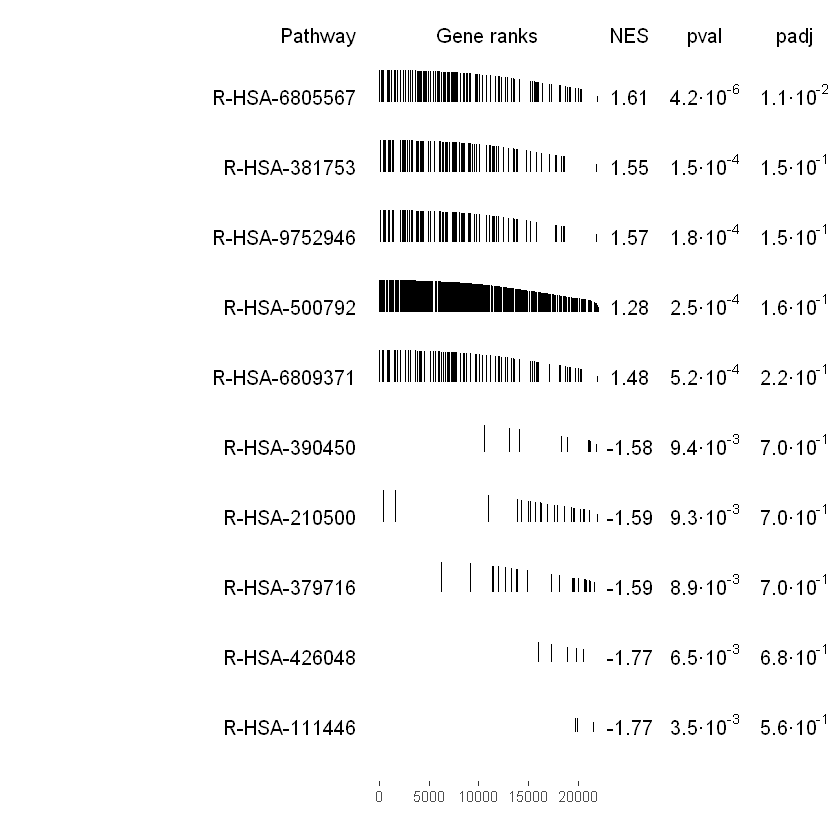

In [85]:
# select the top five up-regulated pathways 
topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n = 5), pathway]
# select the top five down-regulated pathways 
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n = 5), pathway]
# concatenate them for visualization
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
#Viewing the 5 most significantly up-regulated and down-regulated pathways each with the FGSEA internal plot function
plotGseaTable(pathways = REACTOME_hallmark[topPathways], stats = stats, 
              fgseaRes = fgseaRes, gseaParam = 0.5)

## Gene Set Enrichment Analysis using GSA

Gene Set Analysis (GSA), an Enrichment Analysis, is a method that is commonly used to summarize high-dimensional gene expression data sets into sets according to their biological relevance. GSA takes the ranked gene lists from the initial stage of a gene expression analysis and aggregates the genes into sets based on shared biological or functional properties as specified by a reference knowledge base. Such databases often contain phenotype associations, molecular interactions and regulation and are referenced in the analysis of the resultant gene sets to find the relevance of the gene properties to the phenotype of interest.

In [48]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-4.html" width=100% height=250></iframe>')

### Data preparation
The GSA method is freely available as standalone package in CRAN repository. We can use the following code to install the package.

In [49]:
# Install GSA from CRAN
suppressMessages({
    if (!require("GSA")) suppressWarnings(install.packages("GSA"))
})

In [50]:
suppressMessages({
    library(GSA)
})

The GSA method requires an expression matrix, a numeric vector containing the class of each sample and a vector of the genes inputs. We can easily get those inputs by loading the data that we processed in the [**Module 01** ](./Module01-GEO_Data_Processing.ipynb).

In [51]:
# Loading expression data with groups
data <- readRDS("./data/GSE48350.rds")
expression_data <- data$expression_data
norm_expression_data <- data$norm_expression_data
groups <- data$groups

We can also use the sample approach available in the [**Module 01** ](./Module01-GEO_Data_Processing.ipynb) to map the probe IDs to gene symbols. The step-by-step coding instruction is shown below:

In [52]:
# Get the probe IDs
expression_data$PROBEID <- rownames(expression_data)
probeIDs <- rownames(expression_data)
# Perform gene mapping
suppressMessages({
    annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID', 'GENENAME', 'SYMBOL'))
})
# Merge DE result  data frame with annotation table
new_expression_data = merge(annotLookup, expression_data, by = "PROBEID")
# Remove NA value
new_expression_data <- new_expression_data[!is.na(new_expression_data$SYMBOL), ]
# Remove duplicated genes symbol
new_expression_data <- new_expression_data[!duplicated(new_expression_data$SYMBOL, fromLast = FALSE), ]
rownames(new_expression_data) <- new_expression_data$SYMBOL
# Drop PROBEID, GENENAME, and SYMBOL columns
new_expression_data <- new_expression_data[, -c(1:3)]
genenames <- rownames(new_expression_data)

### Enrichment Analysis using GSA and GO Terms
Using data obtained from the previous step, we can run the GSA method by calling the function `GSA`. We can reuse `GO_term_hallmark` and `KEGG_hallmark` loaded in FGSEA to perform analysis. The code details are shown below:

<div class="alert alert-block alert-danger">
    <i class="fa fa-exclamation-circle" aria-hidden="true"></i>
    <b>Alert: </b>  Please note that the outputs generated from GSA can be varied depending on R environments and software versions. Especially, when the users run the scripts using User-managed Notebooks instances which have a preinstalled suite of packages.
</div>

In [53]:
# Getting 
genesets <- GO_term_hallmark
GSA.obj <- GSA(x = as.matrix(new_expression_data), y = as.numeric(groups$groups), 
               genenames = genenames, genesets = genesets, 
               resp.type = "Two class unpaired", nperms = 100, random.seed = 1)

perm= 10 / 100 
perm= 20 / 100 
perm= 30 / 100 
perm= 40 / 100 
perm= 50 / 100 
perm= 60 / 100 
perm= 70 / 100 
perm= 80 / 100 
perm= 90 / 100 
perm= 100 / 100 


To use the `GSA` function, we need to pass the following arguments:

- `x`: Data x: p by n matrix of features (expression values), one observation per column (missing values allowed); y: n-vector of outcome measurements.
- `y`: A vector of response values: 1,2 for two class problem, or 1,2,3 ... for multiclass problem, or real numbers for quantitative or survival problems
- `genesets`: A list containing the gene set collection.
- `genenames`: A vector of genenames in the expression dataset.
- `resp.type`: A character string specifying the problem type: "quantitative" for a continuous parameter; "Two class unpaired"; "Survival" for censored survival outcome; "Multiclass": more than 2 groups, coded 1,2,3...; "Two class paired" for paired outcomes, coded -1,1 (first pair), -2,2 (second pair), etc.
- `nperms`: An integer specifying the number of permutations used to estimate false discovery rates.
- `random.seed`: An integer specifying the optional initial seed for random number generator.

The `GSA` function returns a list containing the analysis results. 

In [54]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj = GSA.obj, geneset.names = names(genesets), FDRcut = .5)

To use the `GSA.listsets` function, we need to pass the following arguments:

- `GSA.obj`: A GSA object returned by GSA function.
- `geneset.names`: An optional vector of names for the gene sets.
- `FDRcut`: A numeric value specifying the false discovery rate cutpoint for listed sets. A value of 1 will cause all sets to be listed.

The `GSA.listsets` function returns a list of the results from the GSA call.

A table of the negative gene sets. “Negative” means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. E.g., for two classes coded 1,2, lower expression correlates with class 2.

In [55]:
neg.table <- res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
57,GO:0000422,-0.4838,0,0
641,GO:0006123,-1.3695,0,0
893,GO:0006851,-0.802,0,0
925,GO:0006906,-0.4592,0,0
976,GO:0007007,-1.2636,0,0
987,GO:0007029,-0.5442,0,0


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y.

In [56]:
pos.table <- res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
1681,GO:0014037,0.7351,0,0
1682,GO:0014044,0.9529,0,0
1713,GO:0014855,0.3543,0,0
1729,GO:0014912,0.6334,0,0
1877,GO:0017145,0.5308,0,0
2009,GO:0021533,0.596,0,0


In [57]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(geneset.number = 10, genesets = genesets, 
               GSA.obj = GSA.obj, genenames = genenames)

Gene,Score
SH3GLB1,2.729
IFT88,2.491
MTMR3,2.271
TP53INP1,2.134
ATG16L2,1.973
ATG2B,1.944
ATG14,1.935
ATG7,1.597
STING1,1.457
MAP1LC3B2,1.385


To use the `GSA.genescores` function, we need to pass the following arguments:

- `geneset.number`: A number specifying which gene set is to be examined.
- `genesets`: A list containing the gene set collection.
- `GSA.obj`: A GSA object returned by the GSA function.
- `genenames`: A vector containing gene names for genes in the expression dataset.

The `GSA.genescores` returns a matrix of gene names and gene scores (eg t-statistics) for each gene in the gene set.


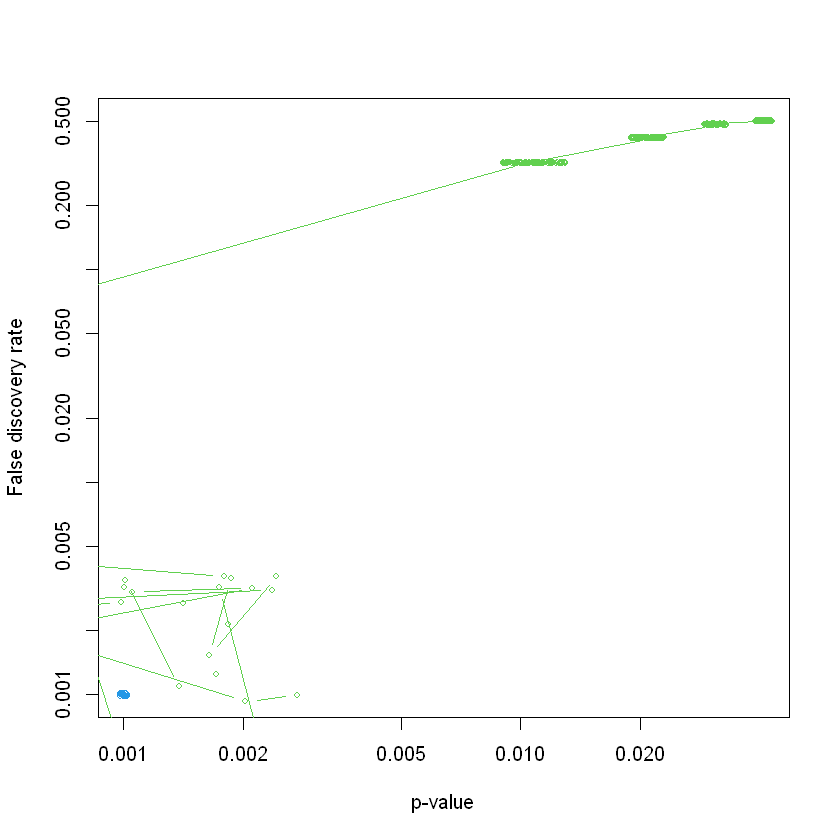

In [58]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac = 1, FDRcut = 0.5))

To use the `GSA.plot` function, we need to pass the following arguments:

- `GSA.obj`: A GSA object returned by the GSA function.
- `fac`: A numeric value for jittering points in plot ("factor" in called to jitter()).
- `FDRcut`: A numeric value specifying the false discovery rate cutpoint for sets to be plotted. A value of 1 (the default) will cause all sets to be plotted.



### Enrichment analysis using GSA and KEGG pathways
We can use the same procedure to per enrichment analysis with the KEGG pathway. All the codes are similar but `genesets` are assigned from `KEGG_hallmark`. The code is shown below.

In [59]:
genesets <- KEGG_hallmark
GSA.obj <- GSA(x = as.matrix(new_expression_data), y = as.numeric(groups$groups), 
               genenames = genenames, genesets = genesets, 
               resp.type = "Two class unpaired", nperms = 100, random.seed = 1)

perm= 10 / 100 
perm= 20 / 100 
perm= 30 / 100 
perm= 40 / 100 
perm= 50 / 100 
perm= 60 / 100 
perm= 70 / 100 
perm= 80 / 100 
perm= 90 / 100 
perm= 100 / 100 


In [60]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj = GSA.obj, geneset.names = names(genesets), FDRcut = .5)

A table of the negative gene sets. "Negative" means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. E.g., for two classes coded 1,2, lower expression correlates with class 2.

In [61]:
neg.table <- res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
214,hsa04260,-0.6732,0,0
239,hsa04723,-0.7029,0,0
15,hsa00190,-1.0477,0.01,0.2485
89,hsa00970,-0.8305,0.01,0.2485
252,hsa04714,-0.5229,0.01,0.2485
318,hsa05010,-0.497,0.01,0.2485


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

In [62]:
pos.table <- res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
7,hsa00053,0.7726,0,0
164,hsa04520,0.474,0,0
169,hsa04810,0.2232,0,0


In [63]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(geneset.number = 10, genesets = genesets, 
               GSA.obj = GSA.obj, genenames = genenames)

Gene,Score
ALDH9A1,2.707
ACSS1,2.612
ADH1B,1.513
GRHPR,0.854
ALDH2,0.768
ALDH3A2,0.726
ALDH7A1,0.64
ACACB,0.455
ADH6,0.346
LDHAL6B,0.22


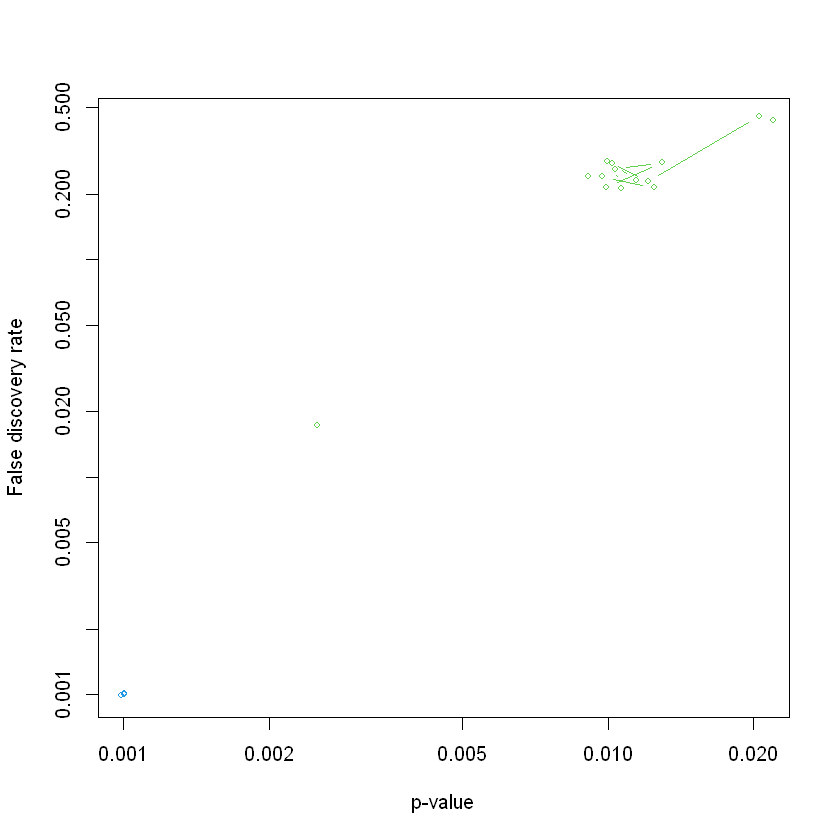

In [64]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac = 1, FDRcut = 0.5))


### Enrichment analysis using GSA and REACTOME pathways
We can use the same procedure to per enrichment analysis with the REACTOME pathway. All the codes are similar but `genesets` are assigned from `REACTOME_hallmark`. The code is shown below.

In [65]:
# Get the probe IDs
expression_data$PROBEID <- rownames(expression_data)
probeIDs <- rownames(expression_data)
# Perform gene mapping
suppressMessages({
    annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID', 'GENENAME', 'ENTREZID'))
})
# Merge DE result  data frame with annotation table
new_expression_data = merge(annotLookup, expression_data, by = "PROBEID")
# Remove NA value
new_expression_data <- new_expression_data[!is.na(new_expression_data$ENTREZID), ]
# Remove duplicated genes ENTREZID
new_expression_data <- new_expression_data[!duplicated(new_expression_data$ENTREZID, fromLast = FALSE), ]
rownames(new_expression_data) <- new_expression_data$ENTREZID
# Drop PROBEID, GENENAME, and ENTREZID columns
new_expression_data <- new_expression_data[, -c(1:3)]
genenames <- rownames(new_expression_data)

In [66]:
genesets <- REACTOME_hallmark
GSA.obj <- GSA(x = as.matrix(new_expression_data), y = as.numeric(groups$groups), 
               genenames = genenames, genesets = genesets, 
               resp.type = "Two class unpaired", nperms = 100, random.seed = 1)

perm= 10 / 100 
perm= 20 / 100 
perm= 30 / 100 
perm= 40 / 100 
perm= 50 / 100 
perm= 60 / 100 
perm= 70 / 100 
perm= 80 / 100 
perm= 90 / 100 
perm= 100 / 100 


In [67]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj = GSA.obj, geneset.names = names(genesets), FDRcut = .5)

In [68]:
neg.table <- res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
149,R-HSA-983168,-0.3143,0,0
187,R-HSA-9612973,-0.3,0,0
266,R-HSA-5607764,-0.4568,0,0
335,R-HSA-390466,-0.5509,0,0
393,R-HSA-6814122,-0.6076,0,0
394,R-HSA-389958,-1.1833,0,0


In [69]:
pos.table <- res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
118,R-HSA-418990,0.5567,0,0
316,R-HSA-446728,0.4345,0,0
320,R-HSA-1500931,0.3282,0,0
981,R-HSA-354194,0.685,0,0
1689,R-HSA-174824,0.2829,0,0
1942,R-HSA-186712,1.4641,0,0


In [70]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(geneset.number = 10, genesets = genesets, 
               GSA.obj = GSA.obj, genenames = genenames)

Gene,Score
55970,2.413
2773,1.846
2771,1.415
2787,1.226
59345,1.134
64805,0.502
2788,0.021
346562,0.012
51764,-0.008
2791,-0.078


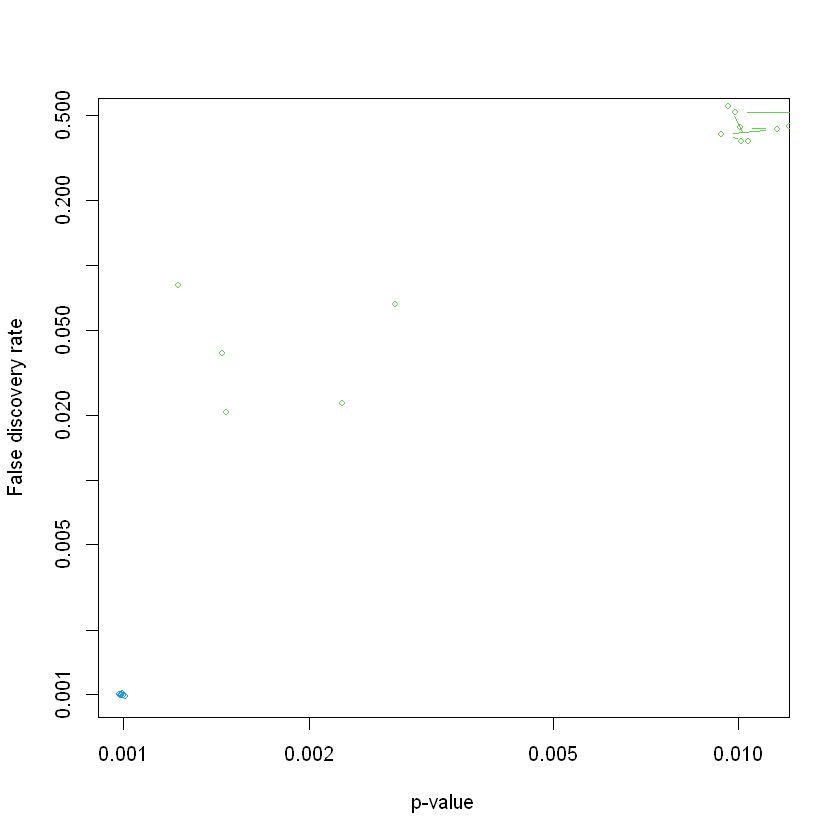

In [71]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac = 1, FDRcut = 0.5))


# Enrichment analysis using PADOG

Pathway Analysis with Down-weighting of Overlapping Genes (PADOG) is a specialized method for enrichment analysis. Focused on deciphering the functional implications of differentially expressed genes in biological pathways, PADOG uniquely emphasizes the uniqueness of genes. Its down-weighting mechanism enhances precision by addressing challenges posed by overlapping genes, offering valuable insights into specific pathways influenced by gene expression changes.

To perform PADOG enrichment analysis, we will use the "PADOG" package. We first need to install and load the package.

In [91]:
suppressWarnings({
    if (!require("BiocManager", quietly = TRUE)) {
        install.packages("BiocManager")
    }
})

suppressWarnings({suppressMessages({BiocManager::install("PADOG")})})

In [92]:
suppressMessages({library(PADOG)})

## Data Preparation

The PADOG method requires the inputs that is quite similar to GSA method. Therefore, to perform analysis using PADOG, we will use the same prepartion steps as for the GSA method above.

In [93]:
# load the expression data, the normalized expression data and the groups
data <- readRDS("./data/GSE48350.rds")
expression_data <- data$expression_data
norm_expression_data <- data$norm_expression_data
groups <- data$groups

# Get the probe IDs
norm_expression_data$PROBEID <- rownames(norm_expression_data)
probeIDs <- rownames(norm_expression_data)
# Perform gene mapping
suppressMessages({
    annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID', 'GENENAME', 'SYMBOL'))
})
# Merge DE result  data frame with annotation table
new_expression_data = merge(annotLookup, norm_expression_data, by = "PROBEID")
# Remove NA value
new_expression_data <- new_expression_data[!is.na(new_expression_data$SYMBOL), ]
# Remove duplicated genes symbol
new_expression_data <- new_expression_data[!duplicated(new_expression_data$SYMBOL, fromLast = FALSE), ]
rownames(new_expression_data) <- new_expression_data$SYMBOL
# Drop PROBEID, GENENAME, and SYMBOL columns
new_expression_data <- new_expression_data[, -c(1:3)]

# Show some first rows of the new expression data
head(new_expression_data)

,GSM300173,GSM300177,GSM300181,GSM300186,GSM300189,GSM300192,GSM300196,GSM300204,GSM300208,GSM300214,⋯,GSM1176201,GSM1176202,GSM1176203,GSM1176204,GSM1176205,GSM1176206,GSM1176207,GSM1176208,GSM1176209,GSM1176210
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DDR1,0.6085351,0.8513945,1.1591995,2.0921063,1.2385797,0.8326798,0.8034588,0.6996407,1.3955209,1.1198790,⋯,1.1563261,1.6152382,1.1901788,1.4972300,0.6329609,1.4160284,1.2335104,1.2999401,0.8595833,1.2998189
RFC2,0.9081397,0.9336113,0.8563885,1.0015364,0.7332213,0.8570584,1.0210657,0.9641521,0.8585522,0.8584299,⋯,0.8848516,0.9385835,1.0359085,0.9225201,1.0405487,0.8187565,0.9541863,0.9855680,1.1704986,0.9924505
HSPA6,0.8674964,0.8385732,0.9956165,0.9797408,3.5688195,1.0145685,1.1729818,1.0208826,0.8163447,0.8572931,⋯,0.9469172,1.3414407,0.9509885,1.3277143,1.0712911,0.9801153,0.9847162,1.4585433,1.2102244,0.9023996
PAX8,1.1053528,1.0432043,1.0137772,1.0931698,1.0356631,0.9435998,1.1165266,1.0960624,1.0099041,1.0553276,⋯,1.0055602,0.8999849,0.9461904,1.2250262,1.0535747,0.9321033,1.0115234,1.0048561,1.1175232,1.0730404
GUCA1A,1.2764652,0.8625501,1.0411838,1.0323309,0.8504494,1.3334491,1.1356378,1.0168769,0.9045680,0.8634836,⋯,1.3178803,0.8809971,0.9128050,1.0231747,1.0368457,0.9140167,1.0870208,0.9601511,3.4069852,1.0806457
UBA7,0.8337133,1.0081274,1.0330204,1.5409547,0.8751729,1.0063332,0.7226255,0.9519509,0.8132348,1.0214182,⋯,1.2466778,1.8324052,0.8732074,1.4028883,0.9107665,0.9586981,1.1221024,1.1861940,1.0770138,1.2797908


In order to perform PADOG enrichment analysis, we will use the `.padog` function bellow. 

### Enrichment analysis using PADOG and GO terms

In [95]:
# Assign the geneset variable to GO_term_hallmark loaded in previous code
geneset <- GO_term_hallmark
# Perform PADOG enrichment analysis using the .padog function
res <- PADOG::padog(esetm = as.matrix(new_expression_data), group = as.character(groups$groups), 
                    gslist = geneset, gs.names = names(geneset), NI = 100, plots = FALSE, 
                    dseed = 1, parallel = TRUE, ncr = 1)
res <- res[, c('ID', 'Ppadog')]
colnames(res) <- c("pathway", "p.value")
head(res)

Starting with 6909 gene sets!
Analyzing 6909 gene sets with 3 or more genes!
# of permutations used: 100 


,pathway,p.value
,<chr>,<dbl>
GO:0065003,GO:0065003,1e-04
GO:0007005,GO:0007005,1e-04
GO:0042773,GO:0042773,1e-04
GO:0042775,GO:0042775,1e-04
GO:0007007,GO:0007007,1e-04
GO:0042407,GO:0042407,1e-04


To use the `padog` function, we need to pass the following arguments:

- `esetm`: A matrix containing log transfomed and normalized gene expression data. Rows correspond to genes and columns to samples.
- `group`: A character vector with the class labels of the samples. It can only contain "c" for control samples or "d" for disease samples.
- `gslist`: Either the value "KEGGRESTpathway" or a list with the gene sets.
- `gs.names`: A character vector with the names of the gene sets. If specified, must have the same length as gslist.

- `NI`: An integer specifying the number of iterations to determine the gene set score significance p-value
- `plots`: A boolean, if set to TRUE then the distribution of the PADOG scores with and without weighting the genes in raw and standardized form are shown using boxplots. A pdf file will be created in the current directory having the name provided in the targetgs field. The scores for the targetgs gene set will be shown in red.
- `dseed`: An integer specifying optional initial seed for random number generator.

- `parallel`: A boolean, if set to TRUE, the NI iterations will be executed in parallel if multiple CPU cores are available and foreach and doRNG packages are installed.
s.
- `ncr`: An integer specifying the number of CPU cores used when parallel set to TRUE. Default is to use all CPU cores detected.

The `padog` function returns a dataframe containing the analysis result.

### Enrichment analysis using PADOG and KEGG pathways

We can use the same procedure to per enrichment analysis with the KEGG pathway. All the codes are similar but `genesets` are loaded from `KEGG_hallmark`. The code is shown below.

In [96]:
# Assign the geneset variable to KEGG_hallmark loaded in previous code
geneset <- KEGG_hallmark
# Perform PADOG enrichment analysis using the .padog function
res <- PADOG::padog(esetm = as.matrix(new_expression_data), group = as.character(groups$groups), 
                    gslist = geneset, gs.names = names(geneset), NI = 100, plots = FALSE, 
                    dseed = 1, parallel = TRUE, ncr = 1)
res <- res[, c('ID', 'Ppadog')]
colnames(res) <- c("pathway", "p.value")
head(res)

Starting with 344 gene sets!
Analyzing 344 gene sets with 3 or more genes!
# of permutations used: 100 


,pathway,p.value
,<chr>,<dbl>
hsa05016,hsa05016,1e-04
hsa05022,hsa05022,1e-04
hsa05012,hsa05012,1e-04
hsa00190,hsa00190,1e-04
hsa05020,hsa05020,1e-04
hsa05010,hsa05010,1e-04


### Enrichment analysis using PADOG and REACTOME pathways

We can use the same procedure to per enrichment analysis with the KEGG pathway. All the codes are similar but `genesets` are loaded from `KEGG_hallmark`, we also need to replace SYMBOL with ENTREZID. The code is shown below.

In [97]:
# load the expression data, the normalized expression data and the groups
data <- readRDS("./data/GSE48350.rds")
expression_data <- data$expression_data
norm_expression_data <- data$norm_expression_data
groups <- data$groups

# Get the probe IDs
norm_expression_data$PROBEID <- rownames(norm_expression_data)
probeIDs <- rownames(norm_expression_data)
# Perform gene mapping
suppressMessages({
    annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID', 'GENENAME', 'ENTREZID'))
})
# Merge DE result  data frame with annotation table
new_expression_data = merge(annotLookup, norm_expression_data, by = "PROBEID")
# Remove NA value
new_expression_data <- new_expression_data[!is.na(new_expression_data$ENTREZID), ]
# Remove duplicated genes ENTREZID
new_expression_data <- new_expression_data[!duplicated(new_expression_data$ENTREZID, fromLast = FALSE), ]
rownames(new_expression_data) <- new_expression_data$ENTREZID
# Drop PROBEID, GENENAME, and ENTREZID columns
new_expression_data <- new_expression_data[, -c(1:3)]

# show some first rows of the new expression data
head(new_expression_data)

,GSM300173,GSM300177,GSM300181,GSM300186,GSM300189,GSM300192,GSM300196,GSM300204,GSM300208,GSM300214,⋯,GSM1176201,GSM1176202,GSM1176203,GSM1176204,GSM1176205,GSM1176206,GSM1176207,GSM1176208,GSM1176209,GSM1176210
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
780,0.6085351,0.8513945,1.1591995,2.0921063,1.2385797,0.8326798,0.8034588,0.6996407,1.3955209,1.1198790,⋯,1.1563261,1.6152382,1.1901788,1.4972300,0.6329609,1.4160284,1.2335104,1.2999401,0.8595833,1.2998189
5982,0.9081397,0.9336113,0.8563885,1.0015364,0.7332213,0.8570584,1.0210657,0.9641521,0.8585522,0.8584299,⋯,0.8848516,0.9385835,1.0359085,0.9225201,1.0405487,0.8187565,0.9541863,0.9855680,1.1704986,0.9924505
3310,0.8674964,0.8385732,0.9956165,0.9797408,3.5688195,1.0145685,1.1729818,1.0208826,0.8163447,0.8572931,⋯,0.9469172,1.3414407,0.9509885,1.3277143,1.0712911,0.9801153,0.9847162,1.4585433,1.2102244,0.9023996
7849,1.1053528,1.0432043,1.0137772,1.0931698,1.0356631,0.9435998,1.1165266,1.0960624,1.0099041,1.0553276,⋯,1.0055602,0.8999849,0.9461904,1.2250262,1.0535747,0.9321033,1.0115234,1.0048561,1.1175232,1.0730404
2978,1.2764652,0.8625501,1.0411838,1.0323309,0.8504494,1.3334491,1.1356378,1.0168769,0.9045680,0.8634836,⋯,1.3178803,0.8809971,0.9128050,1.0231747,1.0368457,0.9140167,1.0870208,0.9601511,3.4069852,1.0806457
7318,0.8337133,1.0081274,1.0330204,1.5409547,0.8751729,1.0063332,0.7226255,0.9519509,0.8132348,1.0214182,⋯,1.2466778,1.8324052,0.8732074,1.4028883,0.9107665,0.9586981,1.1221024,1.1861940,1.0770138,1.2797908


In [98]:
# Assign the geneset variable to KEGG_hallmark loaded in previous code
geneset <- REACTOME_hallmark
# Perform PADOG enrichment analysis using the .padog function
res <- PADOG::padog(esetm = as.matrix(new_expression_data), group = as.character(groups$groups), gslist = geneset,
                        gs.names = names(geneset), NI = 100, plots = FALSE, dseed = 1,
                         parallel = TRUE, ncr = 1)
res <- res[, c('ID', 'Ppadog')]
colnames(res) <- c("pathway", "p.value")
head(res)

Starting with 2647 gene sets!
Analyzing 2198 gene sets with 3 or more genes!
# of permutations used: 100 


,pathway,p.value
,<chr>,<dbl>
R-HSA-1428517,R-HSA-1428517,1e-04
R-HSA-444411,R-HSA-444411,1e-04
R-HSA-210747,R-HSA-210747,1e-04
R-HSA-1852241,R-HSA-1852241,1e-04
R-HSA-210744,R-HSA-210744,1e-04
R-HSA-8949613,R-HSA-8949613,1e-04


The next submodule will go indepth about meta analysis.

In [80]:
sessionInfo()

R version 4.3.2 (2023-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19045)

Matrix products: default


locale:
[1] LC_COLLATE=English_United States.utf8 
[2] LC_CTYPE=English_United States.utf8   
[3] LC_MONETARY=English_United States.utf8
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.utf8    

time zone: America/Chicago
tzcode source: internal

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] PADOG_1.44.0             KEGGdzPathwaysGEO_1.40.0 GSA_1.03.2              
 [4] fgsea_1.28.0             BiocManager_1.30.22      hgu133plus2.db_3.13.0   
 [7] org.Hs.eg.db_3.18.0      AnnotationDbi_1.64.1     IRanges_2.36.0          
[10] S4Vectors_0.40.2         Biobase_2.62.0           BiocGenerics_0.48.1     

loaded via a namespace (and not attached):
 [1] tidyselect_1.2.0        IRdisplay_1.1           dplyr_1.1.4          